In [1]:
%pip install yfinance --quiet
%pip install yfinance statsmodels scikit-learn --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# --- Imports for ARIMA (statsmodels) + Yahoo Finance data ---
import warnings
warnings.filterwarnings("ignore")
%pip install --user yfinance statsmodels scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# --- Pull PLTR historical data from Yahoo Finance ---
stock_data = yf.download("PLTR", start="2018-01-01", progress=False, auto_adjust=False)
stock_data.index.name = "Date"
stock_data = stock_data.fillna(0)

stock_data.head()


Note: you may need to restart the kernel to use updated packages.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,,
2020-09-30,9.50,9.50,11.41,9.11,10.00,338584400
2020-10-01,9.46,9.46,10.10,9.23,9.69,124297600
2020-10-02,9.20,9.20,9.28,8.94,9.06,55018300
2020-10-05,9.03,9.03,9.49,8.92,9.43,36316900
2020-10-06,9.90,9.90,10.18,8.90,9.04,90864000


In [3]:
# --- Minimal drop-in replacement for pmdarima.auto_arima using statsmodels ---
# Finds the best (p,d,q) by AIC (or BIC) over a small grid and returns (order, fitted_model)

import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def auto_arima_like(y, 
                    p_range=range(0, 4), 
                    d_range=range(0, 3), 
                    q_range=range(0, 4),
                    criterion="aic",              # or "bic"
                    enforce_stationarity=False, 
                    enforce_invertibility=False,
                    verbose=False):
    """
    Parameters
    ----------
    y : pandas Series (indexed by Date)
    p_range, d_range, q_range : ranges for orders to try
    criterion : "aic" or "bic"
    Returns
    -------
    order : tuple (p,d,q)
    best_model : fitted statsmodels ARIMAResults
    """
    assert criterion.lower() in {"aic", "bic"}
    best_ic = np.inf
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(y,
                          order=(p, d, q),
                          enforce_stationarity=enforce_stationarity,
                          enforce_invertibility=enforce_invertibility)
            res = model.fit()
            ic = res.aic if criterion.lower() == "aic" else res.bic
            if verbose:
                print(f"Trying ARIMA({p},{d},{q}) -> {criterion.upper()}={ic:.2f}")
            if ic < best_ic:
                best_ic = ic
                best_order = (p, d, q)
                best_model = res
        except Exception as e:
            if verbose:
                print(f"ARIMA({p},{d},{q}) failed: {e}")
            continue

    if best_order is None:
        raise RuntimeError("No ARIMA model could be fit. Try expanding the ranges or differencing the series.")
    if verbose:
        print(f"Selected ARIMA{best_order} with {criterion.upper()}={best_ic:.2f}")
    return best_order, best_model

# --- Example usage with your existing variables ---
# Assumes you've already loaded PLTR prices into `stock_data` via yfinance:
#   stock_data = yf.download("PLTR", start="2018-01-01", progress=False, auto_adjust=False)
# Use Adj Close for modeling
series = stock_data["Adj Close"].dropna()

# Train/test split (e.g., last 20% for test)
split_idx = int(len(series) * 0.8)
train, test = series.iloc[:split_idx], series.iloc[split_idx:]

# Find best (p,d,q) on the training set and get the fitted model
order, fitted = auto_arima_like(train, 
                                p_range=range(0,4), 
                                d_range=range(0,3), 
                                q_range=range(0,4),
                                criterion="aic",
                                verbose=True)

print("Selected ARIMA order:", order)

# Forecast over the test horizon (optional)
n_steps = len(test)
fc = fitted.forecast(steps=n_steps)
fc.index = test.index  # align for plotting/metrics if needed


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,0,0) -> AIC=6752.44
Trying ARIMA(0,0,1) -> AIC=5523.83


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,0,2) -> AIC=4689.82


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,0,3) -> AIC=4074.11
Trying ARIMA(0,1,0) -> AIC=2454.68
Trying ARIMA(0,1,1) -> AIC=2451.94
Trying ARIMA(0,1,2) -> AIC=2448.04
Trying ARIMA(0,1,3) -> AIC=2447.39


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,2,0) -> AIC=3075.95
Trying ARIMA(0,2,1) -> AIC=2458.86


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,2,2) -> AIC=2455.14


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(0,2,3) -> AIC=2451.42
Trying ARIMA(1,0,0) -> AIC=2457.84


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,0,1) -> AIC=2454.29


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,0,2) -> AIC=2449.79


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,0,3) -> AIC=2450.18
Trying ARIMA(1,1,0) -> AIC=2453.18
Trying ARIMA(1,1,1) -> AIC=2452.84


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,1,2) -> AIC=2450.03
Trying ARIMA(1,1,3) -> AIC=2443.59
Trying ARIMA(1,2,0) -> AIC=2798.25


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,2,1) -> AIC=2457.86


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,2,2) -> AIC=2457.93


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1,2,3) -> AIC=2453.38
Trying ARIMA(2,0,0) -> AIC=2454.43


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,0,1) -> AIC=2461.70


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,0,2) -> AIC=2457.77


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,0,3) -> AIC=2448.28
Trying ARIMA(2,1,0) -> AIC=2451.08


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,1,1) -> AIC=2452.92


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,1,2) -> AIC=2440.06


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,1,3) -> AIC=2432.56
Trying ARIMA(2,2,0) -> AIC=2721.76


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,2,1) -> AIC=2457.98


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,2,2) -> AIC=2456.65


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2,2,3) -> AIC=2442.80
Trying ARIMA(3,0,0) -> AIC=2451.89


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(3,0,1) -> AIC=2453.26


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.12/si

Trying ARIMA(3,0,2) -> AIC=2430.60
Trying ARIMA(3,0,3) -> AIC=2437.48
Trying ARIMA(3,1,0) -> AIC=2450.33


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(3,1,1) -> AIC=2444.60


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(3,1,2) -> AIC=2435.67
Trying ARIMA(3,1,3) -> AIC=2441.27
Trying ARIMA(3,2,0) -> AIC=2704.32


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(3,2,1) -> AIC=2457.17


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(3,2,2) -> AIC=2456.65


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trying ARIMA(3,2,3) -> AIC=2446.35
Selected ARIMA(3, 0, 2) with AIC=2430.60
Selected ARIMA order: (3, 0, 2)


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


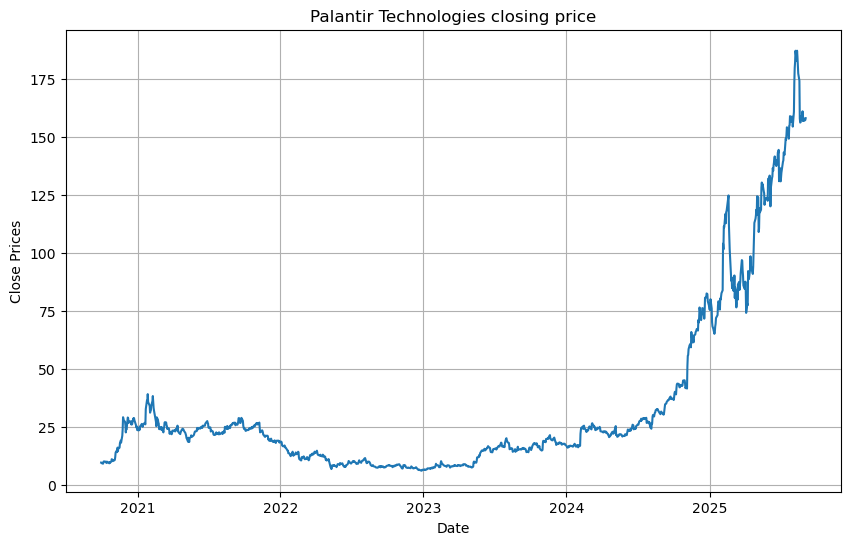

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Palantir Technologies closing price')
plt.show()

<Axes: ylabel='Density'>

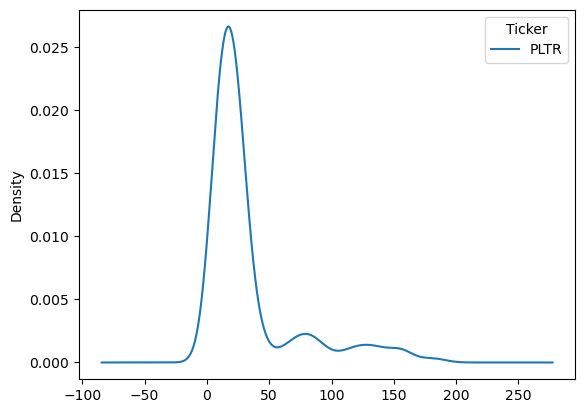

In [5]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

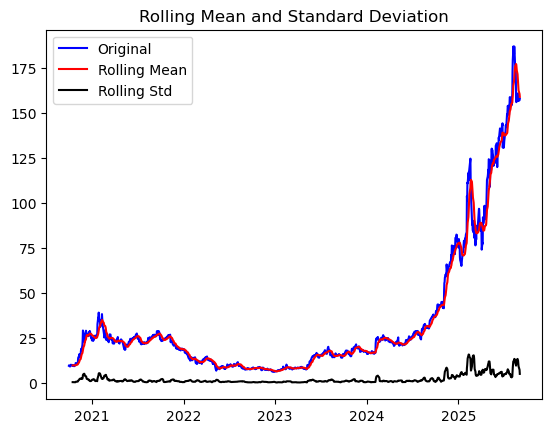

Results of dickey fuller test
Test Statistics                   3.832040
p-value                           1.000000
No. of lags used                 23.000000
Number of observations used    1213.000000
critical value (1%)              -3.435752
critical value (5%)              -2.863926
critical value (10%)             -2.568040
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Axes: ylabel='Density'>

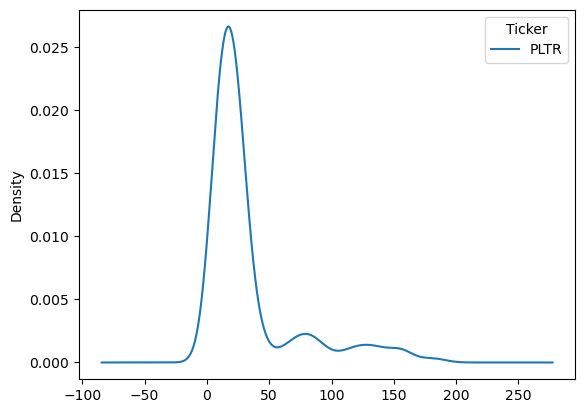

In [7]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

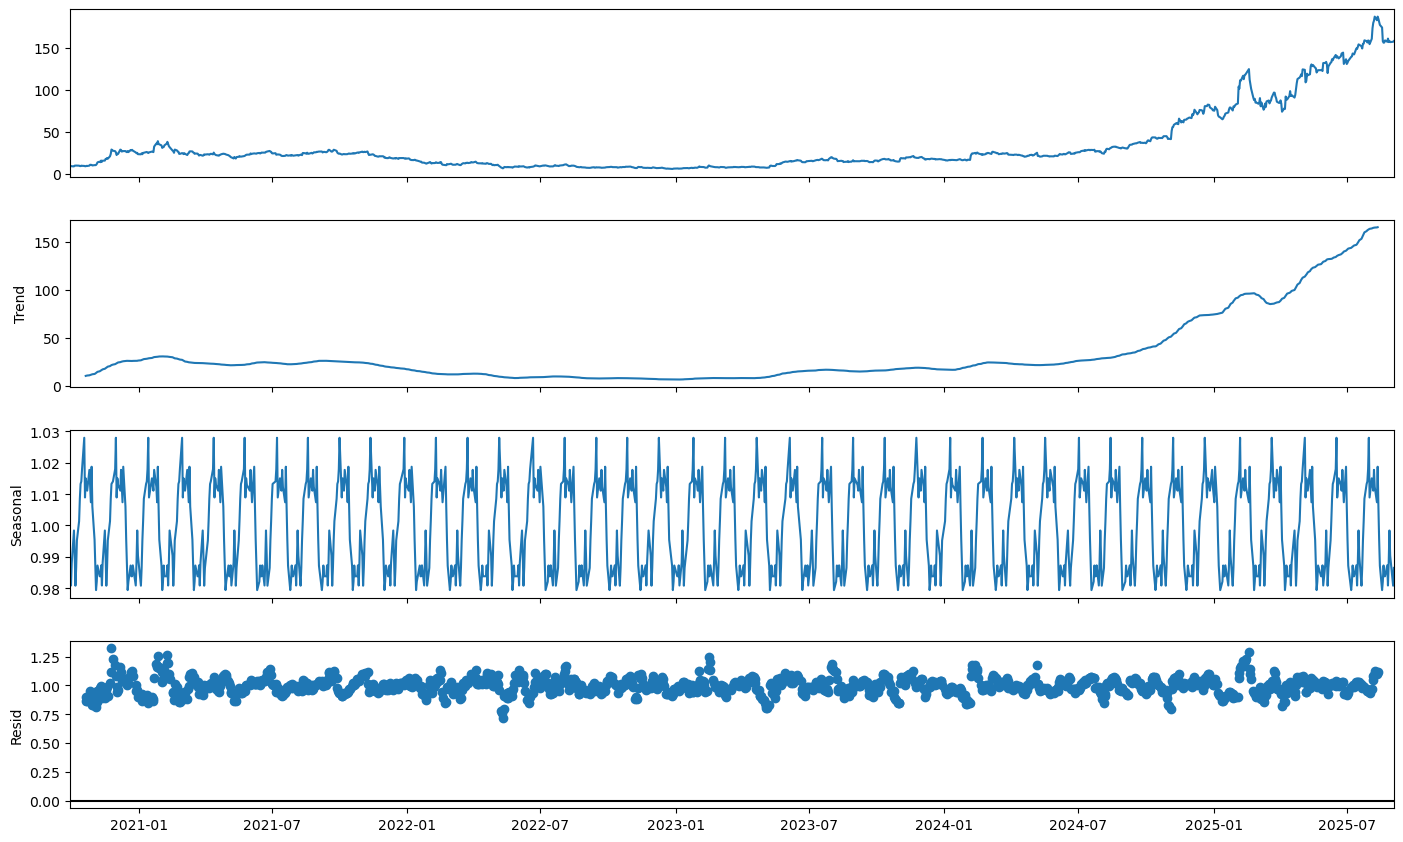

In [10]:
# Decompose the series into trend/seasonal/residual
result = seasonal_decompose(df_close, model='multiplicative', period=30)

# Plot decomposition
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()


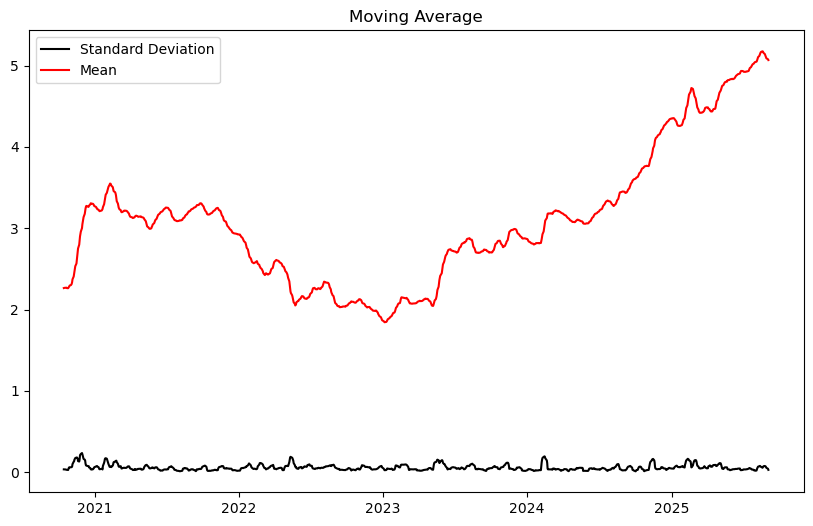

In [11]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

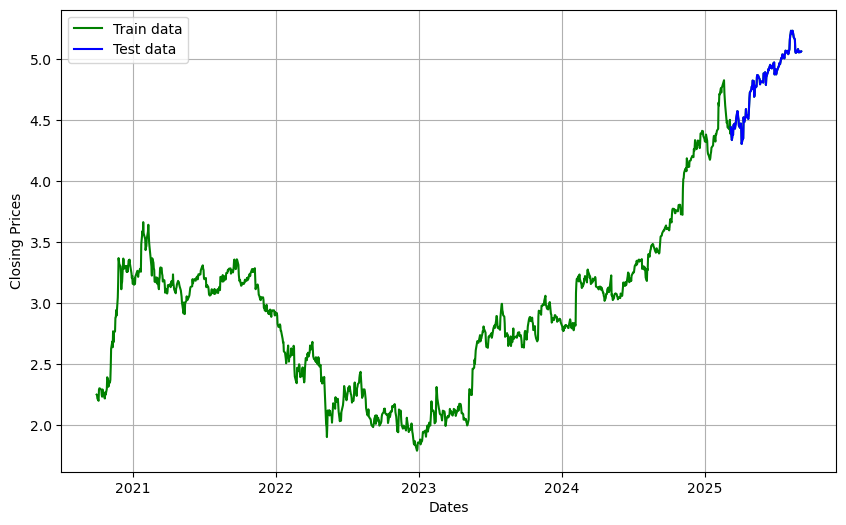

In [12]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Trying ARIMA(0,0,0) -> AIC=2127.62
Trying ARIMA(0,0,1) -> AIC=699.36
Trying ARIMA(0,0,2) -> AIC=-394.54
Trying ARIMA(0,0,3) -> AIC=-1165.36
Trying ARIMA(0,1,0) -> AIC=-3736.57
Trying ARIMA(0,1,1) -> AIC=-3737.56
Trying ARIMA(0,1,2) -> AIC=-3735.32
Trying ARIMA(0,1,3) -> AIC=-3729.65
Trying ARIMA(0,2,0) -> AIC=-3066.41
Trying ARIMA(0,2,1) -> AIC=-3721.94
Trying ARIMA(0,2,2) -> AIC=-3723.27
Trying ARIMA(0,2,3) -> AIC=-3720.51
Trying ARIMA(1,0,0) -> AIC=-3732.81
Trying ARIMA(1,0,1) -> AIC=-3739.72
Trying ARIMA(1,0,2) -> AIC=-3737.43
Trying ARIMA(1,0,3) -> AIC=-3730.22
Trying ARIMA(1,1,0) -> AIC=-3742.65
Trying ARIMA(1,1,1) -> AIC=-3737.00
Trying ARIMA(1,1,2) -> AIC=-3733.49
Trying ARIMA(1,1,3) -> AIC=-3731.27
Trying ARIMA(1,2,0) -> AIC=-3352.12
Trying ARIMA(1,2,1) -> AIC=-3727.75
Trying ARIMA(1,2,2) -> AIC=-3722.15
Trying ARIMA(1,2,3) -> AIC=-3718.78
Trying ARIMA(2,0,0) -> AIC=-3738.81
Trying ARIMA(2,0,1) -> AIC=-3739.03
Trying ARIMA(2,0,2) -> AIC=-3729.59
Trying ARIMA(2,0,3) -> AIC=-3731

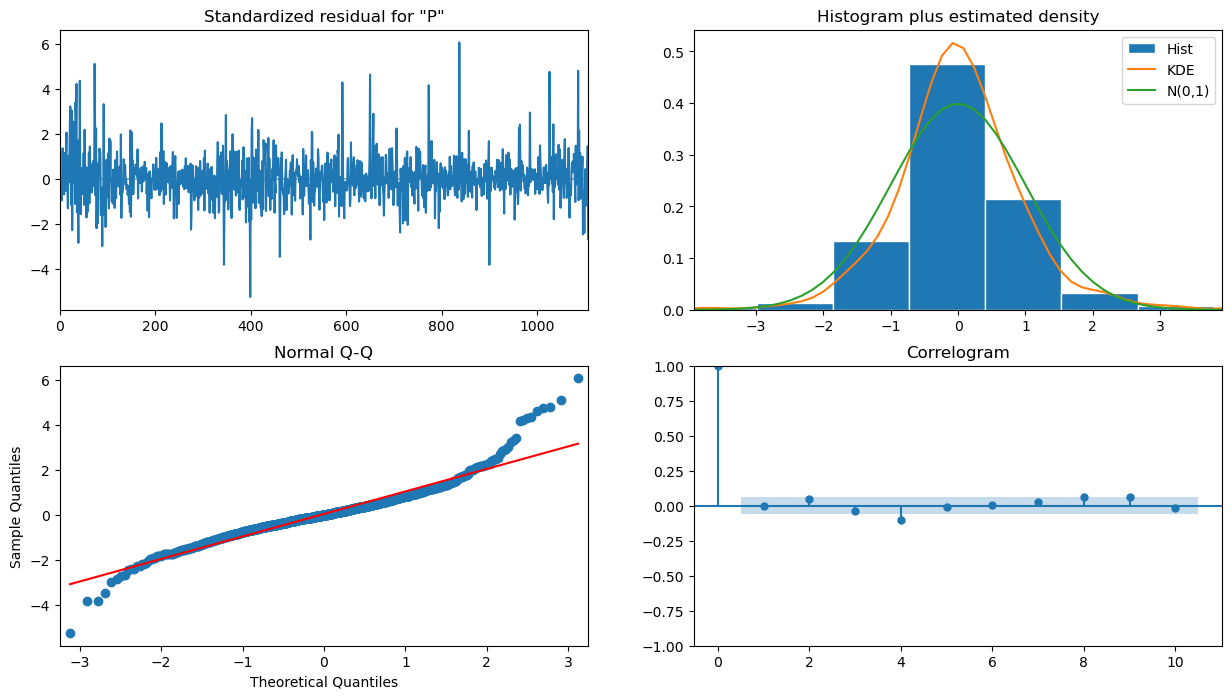

In [13]:
# Instead of auto_arima from pmdarima, use auto_arima_like
order, fitted = auto_arima_like(train_data,
                                p_range=range(0,4),
                                d_range=range(0,3),
                                q_range=range(0,4),
                                criterion="aic",
                                verbose=True)

print("Best order:", order)
print(fitted.summary())

# Diagnostics (similar to plot_diagnostics in pmdarima)
fitted.plot_diagnostics(figsize=(15,8))
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Non-seasonal ARIMA(1,1,0)
model = ARIMA(train_data, order=(1,1,0),
              enforce_stationarity=False,
              enforce_invertibility=False)
fitted = model.fit()
print(type(fitted))        # will be SARIMAXResultsWrapper (normal)
print(fitted.summary())    # header says "SARIMAX Results" (also normal)



<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
                               SARIMAX Results                                
Dep. Variable:                   PLTR   No. Observations:                 1110
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1873.324
Date:                Wed, 03 Sep 2025   AIC                          -3742.648
Time:                        14:13:38   BIC                          -3732.627
Sample:                             0   HQIC                         -3738.858
                               - 1110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0853      0.025      3.401      0.001       0.036       0.134
sigma2         0.0020   4.56e-05     43.636      0.000       0.002       

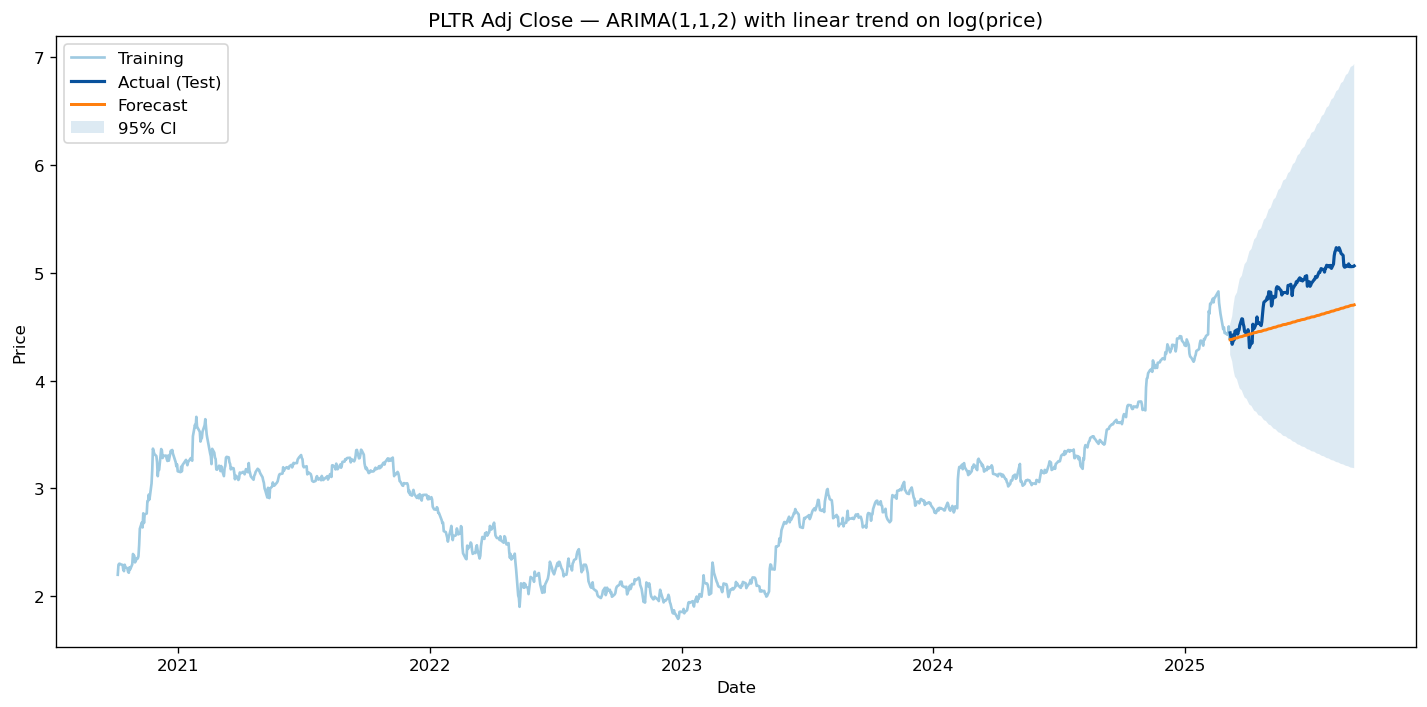

In [15]:
# Refit on LOG prices with linear trend (acts like drift when d=1)
train_data = train_data.astype(float).dropna()
test_data  = test_data.astype(float).dropna()

from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

model = ARIMA(
    np.log(train_data),
    order=(1, 1, 2),
    trend='t',                   # <- use 't' (linear trend), not 'c'
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted = model.fit()

# Forecast and align
steps = len(test_data)
pred = fitted.get_forecast(steps=steps)
fc_log = pred.predicted_mean
conf_log = pred.conf_int(alpha=0.05)

# Back-transform to price level
fc = np.exp(fc_log)
conf = np.exp(conf_log)
fc.index = test_data.index
conf.index = test_data.index

# Plot: training (light blue), actual (dark blue), forecast (orange)
plt.figure(figsize=(12,6), dpi=120)
plt.plot(train_data.index, train_data.values, label='Training', color='#9ecae1', linewidth=1.6)   # light blue
plt.plot(test_data.index,  test_data.values,  label='Actual (Test)', color='#08519c', linewidth=1.9)  # dark blue
plt.plot(fc.index,         fc.values,         label='Forecast', color='#ff7f0e', linewidth=1.8)
plt.fill_between(conf.index, conf.iloc[:,0].values, conf.iloc[:,1].values, alpha=0.15, label='95% CI')

plt.title('PLTR Adj Close — ARIMA(1,1,2) with linear trend on log(price)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
# Align and clean
comparison = pd.concat([test_data, fc], axis=1)
comparison.columns = ['actual', 'forecast']
comparison = comparison.dropna()

# Metrics
mse  = mean_squared_error(comparison['actual'], comparison['forecast'])
mae  = mean_absolute_error(comparison['actual'], comparison['forecast'])
rmse = math.sqrt(mse)

# Safe MAPE (avoids divide-by-zero)
mape = np.mean(
    np.abs((comparison['forecast'] - comparison['actual']) / comparison['actual'].replace(0, np.nan))
) * 100

print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE : 0.1064
MAE : 0.2900
RMSE: 0.3262
MAPE: 5.87%


In [17]:
# --- Make sure we have 1-D aligned series ---
def to_series(x):
    return x.squeeze() if isinstance(x, pd.DataFrame) else x

actual = to_series(test_data).astype(float).dropna()
forecast = to_series(fc).astype(float)

# align forecast to actual (in case of index mismatches)
forecast = forecast.reindex(actual.index).dropna()
actual = actual.reindex(forecast.index)

# pull last values as scalars
last_actual = float(actual.iloc[-1])
last_forecast = float(forecast.iloc[-1])

# % difference between forecast and actual
diff_pct = (last_forecast - last_actual) / last_actual * 100.0

# signal
if diff_pct > 5:
    arima_signal = "BUY"
elif diff_pct < -5:
    arima_signal = "SELL"
else:
    arima_signal = "HOLD"

print("ARIMA Forecast Signal:", arima_signal)
print(f"Last Actual Price : {last_actual:.2f}")
print(f"Last Forecasted   : {last_forecast:.2f}")
print(f"Forecast vs Actual: {diff_pct:.2f}%")


ARIMA Forecast Signal: SELL
Last Actual Price : 5.06
Last Forecasted   : 4.70
Forecast vs Actual: -7.13%


In [18]:
import yfinance as yf

ticker = yf.Ticker("PLTR")
info = ticker.info

fundamentals = {
    "Market Cap": info.get("marketCap"),
    "PE Ratio": info.get("trailingPE"),
    "Forward PE": info.get("forwardPE"),
    "PEG Ratio": info.get("pegRatio"),
    "Profit Margin": info.get("profitMargins"),
    "Revenue Growth": info.get("revenueGrowth"),
    "EPS (ttm)": info.get("trailingEps"),
    "Debt/Equity": info.get("debtToEquity"),
    "Return on Equity": info.get("returnOnEquity"),
}
print("\n=== PLTR Fundamentals ===")
for k,v in fundamentals.items():
    print(f"{k}: {v}")



=== PLTR Fundamentals ===
Market Cap: 374011265024
PE Ratio: 525.51666
Forward PE: 335.43616
PEG Ratio: None
Profit Margin: 0.22185
Revenue Growth: 0.48
EPS (ttm): 0.3
Debt/Equity: 3.947
Return on Equity: 0.15203


In [19]:
# Simple fundamental overlay
if fundamentals["PE Ratio"] and fundamentals["PE Ratio"] > 60:
    fundamental_bias = "Overvalued"
elif fundamentals["Revenue Growth"] and fundamentals["Revenue Growth"] > 0.15:
    fundamental_bias = "Strong Growth"
else:
    fundamental_bias = "Neutral"

print("\n=== Final Recommendation ===")
print(f"ARIMA Signal     : {arima_signal} (based on {diff_pct:.2f}% diff)")
print(f"Fundamental Bias : {fundamental_bias}")

if arima_signal == "BUY" and fundamental_bias == "Strong Growth":
    print(">> Recommendation: BUY (forecast upside + strong fundamentals)")
elif arima_signal == "SELL" and fundamental_bias == "Overvalued":
    print(">> Recommendation: SELL (forecast downside + stretched valuation)")
else:
    print(">> Recommendation: HOLD (signals mixed)")



=== Final Recommendation ===
ARIMA Signal     : SELL (based on -7.13% diff)
Fundamental Bias : Overvalued
>> Recommendation: SELL (forecast downside + stretched valuation)
